# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 80*u.arcsec, -25*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = int(np.random.uniform(0,100000))

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = True

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':'gaussian',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [6, 4]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 49 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   1540.6   ] kpc ; [   6.083    ,   4.083    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Define the mask
ramap, decmap = map_tools.get_radec_map(mock.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 

In [8]:
#===== Initiate a data object and fake data
#----- Init with the mock
data1 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM,transfer_function=TF, noise_model=[noise_r, noise_k], mask=mask,
                    output_dir=output_dir, silent=True)
data2 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM,transfer_function=TF, noise_model=[noise_r, noise_k], mask=mask,
                    output_dir=output_dir, silent=True)

#----- Define the noise properties
data1.noise_mc = data1.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data1.noise_rms = data1.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

data2.noise_mc = data2.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data2.noise_rms = data2.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

#----- Mock the data
img1 = data1.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)
img2 = data2.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


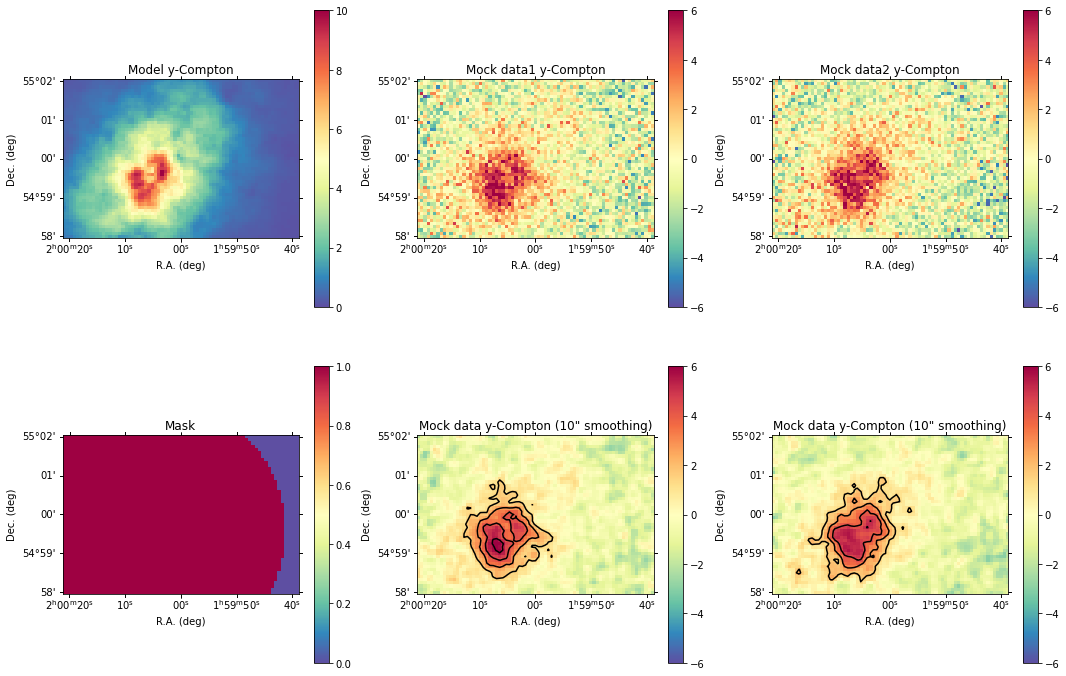

In [9]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(mock.get_map_header()))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data1.header))
plt.imshow(data1.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data1 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data2.header))
plt.imshow(data2.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data2 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data1.header))
plt.imshow(data1.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data1.header))
plt.imshow(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data1.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data1.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data2.header))
plt.imshow(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data2.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data2.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

In [10]:
model = copy.deepcopy(mock)

# Radial profile constraints

In [11]:
RadInf1 = pitszi.InferenceRadial(data1, model, 
                                 method_use_covmat=method_use_covmat,method_parallel=method_parallel,
                                 mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                 mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                 mcmc_Nresamp=mcmc_Nresamp,
                                 output_dir=output_dir, silent=True)
RadInf2 = pitszi.InferenceRadial(data2, model, 
                                 method_use_covmat=method_use_covmat,method_parallel=method_parallel,
                                 mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                 mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                 mcmc_Nresamp=mcmc_Nresamp,
                                 output_dir=output_dir, silent=True)

In [12]:
fitpar_prof = {
    #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
    #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    #'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
    #'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
    #'RA': {'guess':[RA.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-1, RA.to_value('arcmin')+1]},
    #'Dec': {'guess':[Dec.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-1, Dec.to_value('arcmin')+1]},
    'ZL':{'guess':[0,1e-5],'unit':None},
              }

In [13]:
Pname, Popt1, Pcov1 = RadInf1.run_curvefit_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)

param 0 (M500): 
   median   = 9.04413584135693 -0.1362600950760644 +0.13391214976317123
   best-fit = 9.0454335002171 -0.13755775393623537 +0.13261449090300026
   M500 = 9.04413584135693_{-0.1362600950760644}^{0.13391214976317123}
param 1 (ZL): 
   median   = 2.255589403481316e-07 -2.4256752011158863e-07 +2.4819468491232616e-07
   best-fit = 3.402759218411051e-07 -3.5728450160456215e-07 +1.334777034193527e-07
   ZL = 2.255589403481316e-07_{-2.4256752011158863e-07}^{2.4819468491232616e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [14]:
Pname, Popt2, Pcov2 = RadInf2.run_curvefit_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)

param 0 (M500): 
   median   = 9.721774755444802 -0.13645323584209734 +0.13664184952585323
   best-fit = 9.718778186418481 -0.13345666681577661 +0.13963841855217396
   M500 = 9.721774755444802_{-0.13645323584209734}^{0.13664184952585323}
param 1 (ZL): 
   median   = -6.090715141002337e-08 -2.46830339036755e-07 +2.4567434032389886e-07
   best-fit = 4.9173550099199995e-08 -3.569110405459783e-07 +1.355936388146755e-07
   ZL = -6.090715141002337e-08_{-2.46830339036755e-07}^{2.4567434032389886e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


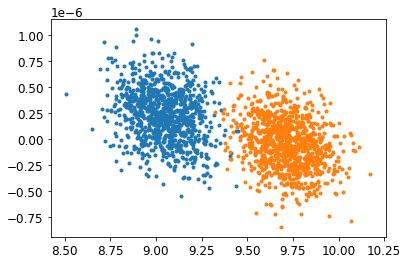

In [15]:
Nsample = 1000
par_chains1 = np.zeros((Nsample, len(fitpar_prof)))
par_chains2 = np.zeros((Nsample, len(fitpar_prof)))

for isamp in range(Nsample):
    par_chains1[isamp,:] = np.random.multivariate_normal(Popt1, Pcov1)
    par_chains2[isamp,:] = np.random.multivariate_normal(Popt2, Pcov2)

plt.plot(par_chains1[:,0], par_chains1[:,1], marker='.', ls='')
plt.plot(par_chains2[:,0], par_chains2[:,1], marker='.', ls='')

# Pk constraints

In [16]:
method_use_covmat = True

In [17]:
FlucInf1 = pitszi.InferenceFluctuation(data1, model, 
                                       method_use_covmat=method_use_covmat, method_parallel=method_parallel, method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                       mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                       mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=False)

FlucInf1.set_method_w8(apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, smooth_FWHM=method_w8_smooth)

FlucInf1.pk_setup()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 6.  2.  8. 12. 10. 16.  8. 24. 12. 20. 22. 16. 32. 26. 22. 34. 32. 36.
 26. 42. 38. 44. 36. 44. 50. 40. 56. 38. 62. 54.]
      - Minimal count in k bins: 2.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing
----- The setup is done -----


In [18]:
FlucInf2 = pitszi.InferenceFluctuation(data2, model, 
                                       method_use_covmat=method_use_covmat, method_parallel=method_parallel, method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                       mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                       mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=True)

FlucInf2.set_method_w8(apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, smooth_FWHM=method_w8_smooth)

FlucInf2.pk_setup()

In [19]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [20]:
Pname, Popt1, Pcov1 = FlucInf1.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.3637017404786388 -0.04714409860659258 +0.04764236574370978
   best-fit = 0.411263354932646 -0.09470571306059977 +8.075128970258527e-05
   Norm = 0.3637017404786388_{-0.04714409860659258}^{0.04764236574370978}
param 1 (Linj): 
   median   = 1034.132451547012 -161.93893379033045 +158.42494392794583
   best-fit = 1035.5410442752705 -163.347526518589 +157.01635119968728
   Linj = 1034.132451547012_{-161.93893379033045}^{158.42494392794583}
param 2 (Anoise): 
   median   = 1.1125857024739476 -0.056504426879393055 +0.05532882292288965
   best-fit = 1.15155510216066 -0.09547382656610548 +0.01635942323617723
   Anoise = 1.1125857024739476_{-0.056504426879393055}^{0.05532882292288965}


In [21]:
Pname, Popt2, Pcov2 = FlucInf2.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.3387739947048845 -0.08880163225999335 +0.0900861221150912
   best-fit = 0.44226713732539547 -0.1922947748805043 +-0.013407020505419753
   Norm = 0.3387739947048845_{-0.08880163225999335}^{0.0900861221150912}
param 1 (Linj): 
   median   = 714.1609178338824 -173.9658217454339 +175.81079879290962
   best-fit = 715.8340546992013 -175.63895861075275 +174.13766192759078
   Linj = 714.1609178338824_{-173.9658217454339}^{175.81079879290962}
param 2 (Anoise): 
   median   = 1.071494227672368 -0.06052432831514598 +0.06046148711000776
   best-fit = 1.0093131539635132 --0.0016567453937088583 +0.1226425608188626
   Anoise = 1.071494227672368_{-0.06052432831514598}^{0.06046148711000776}


In [24]:
Pname, samp1 = FlucInf1.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- No existing sampler found
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj' 'Anoise']
      - Starting point mean:          
[5.e-01 8.e+02 1.e+00]
      - Starting point dispersion :   
[5.e-01 5.e+02 2.e-01]
      - Minimal starting point:       
[  0 100   0]
      - Maximal starting point:       
[   3 3000    2]
      - Number of dimensions:         
3
      - Parallel mode:                
False
      - Use covariance matrix?        
True
-----
----- Does the sampler already exist? -----
      - No, start from scratch
----- MCMC sampling -----
      - Runing 500 MCMC steps


100%|██████████| 500/500 [14:31<00:00,  1.74s/it]


param 0 (Norm): 
   median   = 0.33986058359947247 -0.052053051802740335 +0.048057321550857623
   best-fit = 0.3660636270277493 -0.07825609523101718 +0.021854278122580784
   Norm = 0.33986058359947247_{-0.052053051802740335}^{0.048057321550857623}
param 1 (Linj): 
   median   = 1129.3467597913136 -189.05082540240392 +389.1306700255873
   best-fit = 1031.814122935147 -91.5181885462373 +486.6633068817539
   Linj = 1129.3467597913136_{-189.05082540240392}^{389.1306700255873}
param 2 (Anoise): 
   median   = 1.1190735375483032 -0.05771812027897005 +0.054708564235069534
   best-fit = 1.111256210195223 -0.04990079292588989 +0.0625258915881497
   Anoise = 1.1190735375483032_{-0.05771812027897005}^{0.054708564235069534}


In [25]:
Pname, samp2 = FlucInf2.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists


100%|██████████| 500/500 [15:05<00:00,  1.81s/it]


param 0 (Norm): 
   median   = 0.33681609374637156 -0.1418495828866352 +0.20974364531195333
   best-fit = 0.3335254059187941 -0.13855889505905775 +0.2130343331395308
   Norm = 0.33681609374637156_{-0.1418495828866352}^{0.20974364531195333}
param 1 (Linj): 
   median   = 648.5741489575794 -296.816150483259 +310.47912556272456
   best-fit = 743.070680756334 -391.3126822820136 +215.98259376396993
   Linj = 648.5741489575794_{-296.816150483259}^{310.47912556272456}
param 2 (Anoise): 
   median   = 1.0890620003476692 -0.06456629335741138 +0.06387144107509202
   best-fit = 1.0827804444717026 -0.058284737481444804 +0.07015299695105859
   Anoise = 1.0890620003476692_{-0.06456629335741138}^{0.06387144107509202}


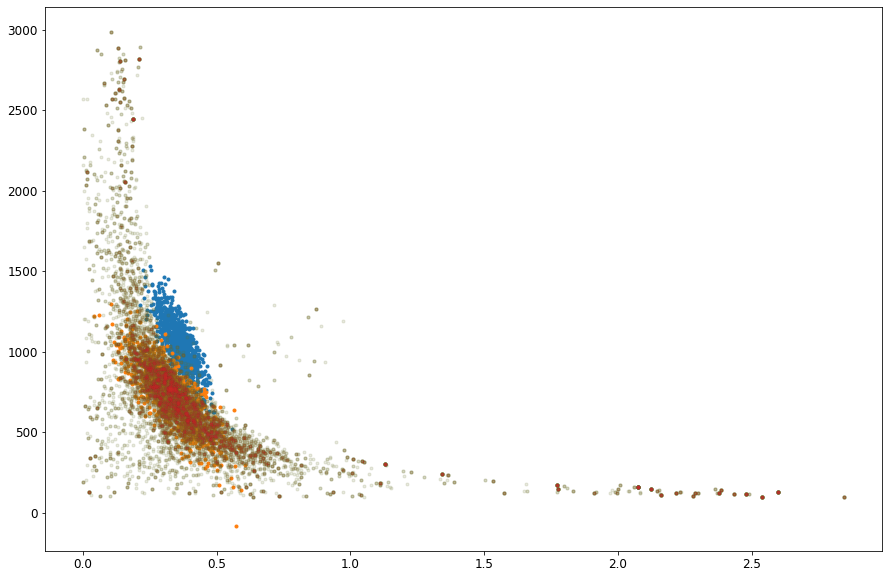

In [38]:
Nsample = 1000
par_chains1 = np.zeros((Nsample, len(fitpar_pk3d)))
par_chains2 = np.zeros((Nsample, len(fitpar_pk3d)))

for isamp in range(Nsample):
    par_chains1[isamp,:] = np.random.multivariate_normal(Popt1, Pcov1)
    par_chains2[isamp,:] = np.random.multivariate_normal(Popt2, Pcov2)

plt.figure(0, figsize=(15,10))
plt.plot(par_chains1[:,0], par_chains1[:,1], marker='.', ls='')
plt.plot(par_chains2[:,0], par_chains2[:,1], marker='.', ls='')
plt.plot(samp1.flatchain[:,0], samp1.flatchain[:,1], marker='.', ls='', alpha=0.1)
plt.plot(samp2.flatchain[:,0], samp2.flatchain[:,1], marker='.', ls='', alpha=0.05)